In [ ]:
import os
os.chdir("/content/drive/MyDrive")

In [ ]:
%%capture
!pip install scanpy
!pip install scikit-misc

In [ ]:
import scanpy as sc
import numpy as np

In [ ]:
adata = sc.read_10x_mtx("donor1_filtered_feature_bc_matrix", cache = True)
sc.pp.filter_cells(adata, min_genes = 200)
sc.pp.filter_genes(adata, min_cells = 3)

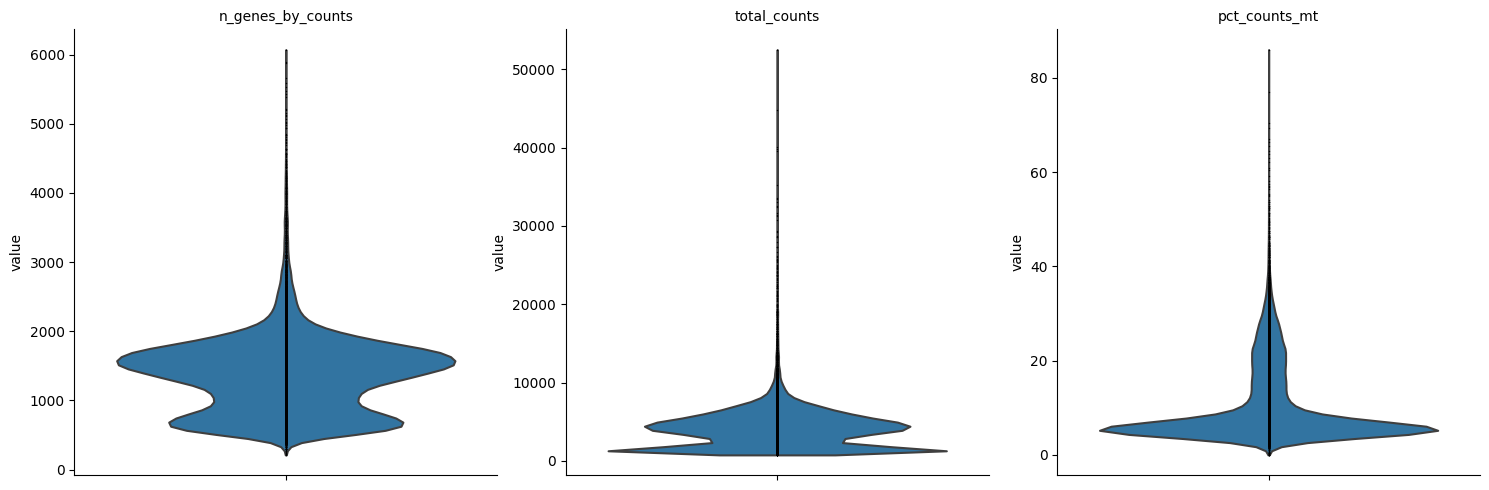

In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars = ['mt'], percent_top = None, log1p = False, inplace = True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter = 0, multi_panel = True)

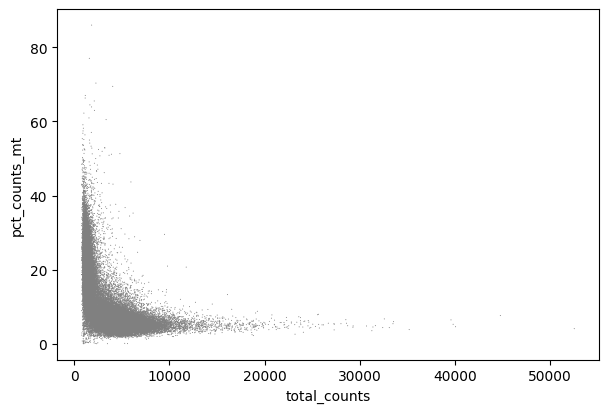

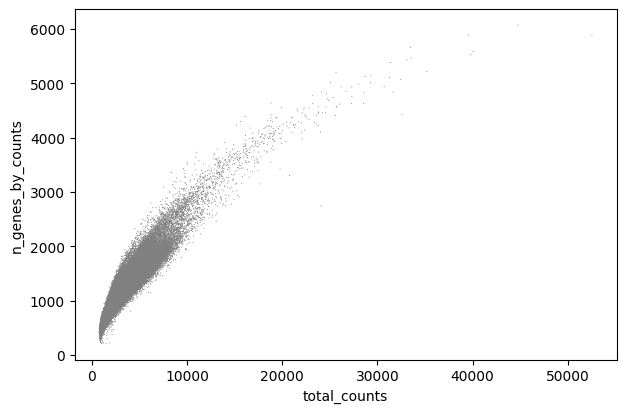

In [ ]:
sc.pl.scatter(adata, x = 'total_counts', y = 'pct_counts_mt')
sc.pl.scatter(adata, x = 'total_counts', y = 'n_genes_by_counts')

In [ ]:
adata = adata[adata.obs.pct_counts_mt < 15, :]
adata = adata[adata.obs.n_genes_by_counts < 4500, :]

In [ ]:
sc.set_figure_params(figsize=(4, 4), frameon=False)

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [ ]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=10e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", layer="counts", n_top_genes=1024, subset=True
)

In [ ]:
adata.X.shape

(43063, 1024)

In [ ]:
with open("donor1_binarized_matrix.csv") as table:
  header = table.readline()
  content = table.readlines()
header = header.rstrip("\n").split(",")
for i in range(len(content)):
  content[i] = content[i].rstrip("\n").split(",")
print(header)
print(content[0])
print(len(content))

['barcode', 'donor', 'cell_clono_cdr3_aa', 'cell_clono_cdr3_nt', 'CD3', 'CD19', 'CD45RA', 'CD4', 'CD8a', 'CD14', 'CD45RO', 'CD279_PD-1', 'IgG1', 'IgG2a', 'IgG2b', 'CD127', 'CD197_CCR7', 'HLA-DR', 'A0101_VTEHDTLLY_IE-1_CMV', 'A0201_KTWGQYWQV_gp100_Cancer', 'A0201_ELAGIGILTV_MART-1_Cancer', 'A0201_CLLWSFQTSA_Tyrosinase_Cancer', 'A0201_IMDQVPFSV_gp100_Cancer', 'A0201_SLLMWITQV_NY-ESO-1_Cancer', 'A0201_KVAELVHFL_MAGE-A3_Cancer', 'A0201_KVLEYVIKV_MAGE-A1_Cancer', 'A0201_CLLGTYTQDV_Kanamycin-B-dioxygenase', 'A0201_LLDFVRFMGV_EBNA-3B_EBV', 'A0201_LLMGTLGIVC_HPV-16E7_82-91', 'A0201_CLGGLLTMV_LMP-2A_EBV', 'A0201_YLLEMLWRL_LMP1_EBV', 'A0201_FLYALALLL_LMP2A_EBV', 'A0201_GILGFVFTL_Flu-MP_Influenza', 'A0201_GLCTLVAML_BMLF1_EBV', 'A0201_NLVPMVATV_pp65_CMV', 'A0201_ILKEPVHGV_RT_HIV', 'A0201_FLASKIGRLV_Ca2-indepen-Plip-A2', 'A2402_CYTWNQMNL_WT1-(235-243)236M_Y', 'A0201_RTLNAWVKV_Gag-protein_HIV', 'A0201_KLQCVDLHV_PSA146-154', 'A0201_LLFGYPVYV_HTLV-1', 'A0201_SLFNTVATL_Gag-protein_HIV', 'A0201_SLYNTVAT

In [ ]:
import re
barcode = []
tra = []
trb = []
rna = []
specificity = []
max_length = 0
if "True" not in content[0]:
  specificity_start = content[0].index("False")
else:
  specificity_start = min(content[0].index("False"), content[0].index("True"))
for line in content:
  _barcode = line[header.index("barcode")]
  _chains = line[header.index("cell_clono_cdr3_aa")]
  _tra = re.findall("TRA:(\w+)", _chains)
  _trb = re.findall("TRB:(\w+)", _chains)
  if len(_tra) == 1 and len(_trb) == 1 and _barcode in adata.obs_names:
    barcode.append(_barcode)
    tra.append(_tra[0])
    trb.append(_trb[0])
    rna.append(np.array(adata[_barcode].X.todense().tolist()[0]))
    if "True" in line:
      specificity.append(line.index("True") - specificity_start)
    else:
      specificity.append(-1)
    if len(_tra[0]) > max_length:
      max_length = len(_tra[0])
    if len(_trb[0]) > max_length:
      max_length = len(_trb[0])
rna = np.array(rna)
print(len(barcode))

28250


In [ ]:
print(barcode[0], tra[0], trb[0], rna[0][ : 10], specificity[0])

AAACCTGAGAGCCCAA-5 CASYTDKLIF CASSGGSISTDTQYF [3.07848144 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ] -1


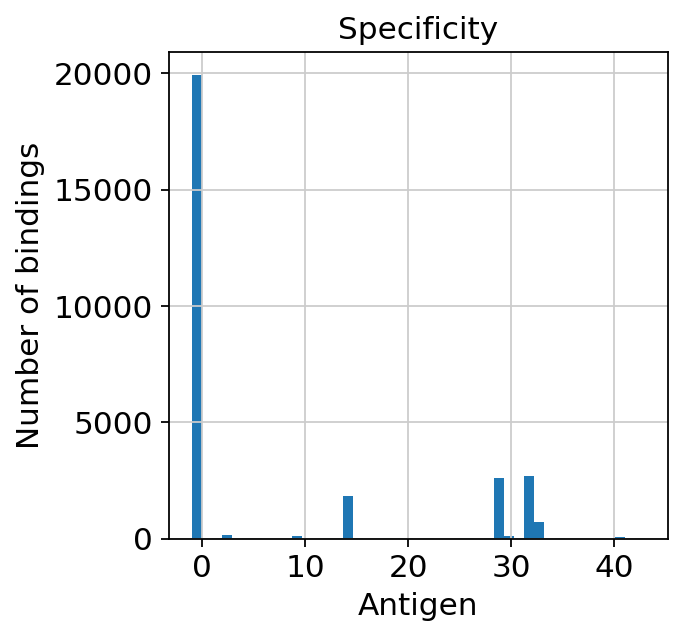

In [ ]:
import matplotlib.pyplot as plt
plt.hist(specificity, bins = max(specificity) - min(specificity) + 1)
plt.title("Specificity")
plt.xlabel("Antigen")
plt.ylabel("Number of bindings")
plt.show()

In [ ]:
adata.obs["specificity"] = -1
for i in range(len(barcode)):
  if specificity[i] != -1 and barcode[i] in adata.obs_names:
    adata.obs.loc[adata.obs.index.isin([barcode[i]]), "specificity"]  = specificity[i]

In [ ]:
adata.obs[:5]

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,specificity
AAACGGGAGAAGATTC-1,1872,1872,5013.0,222.0,4.428486,29
AAACGGGTCGGACAAG-1,1512,1512,3827.0,255.0,6.663182,-1
AAAGATGGTACAGACG-1,1912,1911,7091.0,339.0,4.780708,-1
AAAGTAGAGACGCTTT-1,1740,1740,6209.0,432.0,6.957642,-1
AAAGTAGAGCGCTTAT-1,1698,1698,5800.0,289.0,4.982759,-1


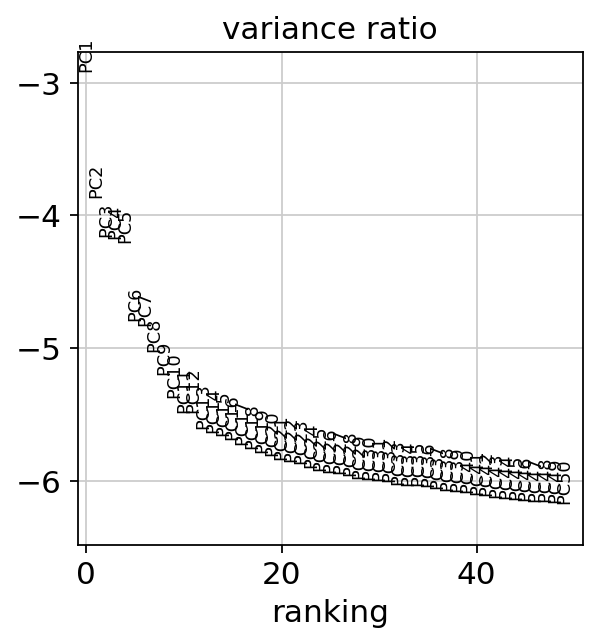

In [ ]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

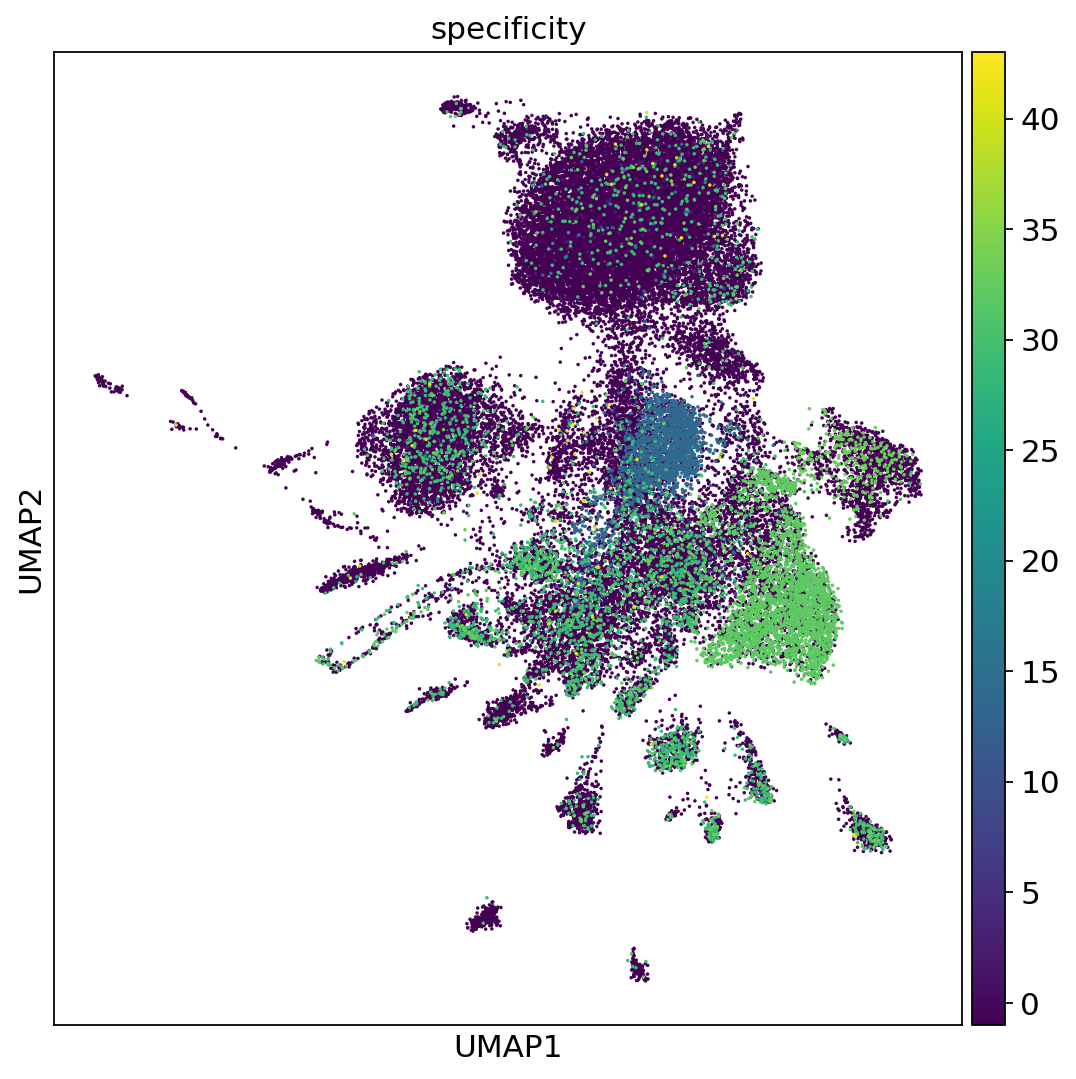

In [ ]:
sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata, color=['specificity'], size = 10)

In [ ]:
for i in range(len(tra)):
  mid = len(tra[i]) // 2
  tra[i] = list(tra[i][:mid] + "_" * (max_length - len(tra[i])) + tra[i][mid:])

for i in range(len(trb)):
  mid = len(trb[i]) // 2
  trb[i] = list(trb[i][:mid] + "_" * (max_length - len(trb[i])) + trb[i][mid:])

In [ ]:
amino_acid_indexes = {
    "_": 0,
    "A": 1,
    "R": 2,
    "N": 3,
    "D": 4,
    "C": 5,
    "Q": 6,
    "E": 7,
    "G": 8,
    "H": 9,
    "I": 10,
    "L": 11,
    "K": 12,
    "M": 13,
    "F": 14,
    "P": 15,
    "S": 16,
    "T": 17,
    "W": 18,
    "Y": 19,
    "V": 20
}
print(tra[0])
for i in range(len(tra)):
  for j in range(len(tra[i])):
    tra[i][j] = amino_acid_indexes.get(tra[i][j])
print(tra[0])

for i in range(len(trb)):
  for j in range(len(trb[i])):
    trb[i][j] = amino_acid_indexes.get(trb[i][j])

['C', 'A', 'S', 'Y', 'T', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'D', 'K', 'L', 'I', 'F']
[5, 1, 16, 19, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 12, 11, 10, 14]


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models

In [ ]:
embedding_model = models.Sequential()
embedding_model.add(layers.Embedding(len(tra) + len(trb), 21, input_length=max_length))
embedding_model.compile('rmsprop', 'mse')
embedding = embedding_model.predict(tra + trb)

1766/1766 [==============================] - 3s 2ms/step


In [ ]:
print(embedding.shape)
assert len(embedding) % 2 == 0

(56500, 26, 21)


In [ ]:
tra_embedding = embedding[: int(len(embedding) / 2)]
trb_embedding = embedding[int(len(embedding) / 2) :]
assert len(tra_embedding) == len(trb_embedding)

In [ ]:
np.save("Preprocessed Data/barcode.npy", barcode)
np.save("Preprocessed Data/tra.npy", tra)
np.save("Preprocessed Data/tra_embedding.npy", tra_embedding)
np.save("Preprocessed Data/trb.npy", trb)
np.save("Preprocessed Data/trb_embedding.npy", trb_embedding)
np.save("Preprocessed Data/rna.npy", rna)
np.save("Preprocessed Data/specificity.npy", specificity)